### HuggingFace Tutorial

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import joblib
import sys
import os
from huggingface_hub import HfFolder,notebook_login,HfApi,snapshot_download
from dotenv import load_dotenv

### Login into Huggingface and paste your API token below

In [7]:
notebook_login()

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Assuming the current directory is 'models', get the path of the 'TAQ-Query-Scripts' directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

token = os.getenv("hf_token")
user_token= os.getenv("hf_user_token")

# Use the token to authenticate
HfFolder.save_token(token)

### OLS Walkthrough

                            OLS Regression Results                            
Dep. Variable:            Trade_Price   R-squared:                      -5.217
Model:                            OLS   Adj. R-squared:                 -5.232
Method:                 Least Squares   F-statistic:                    -333.6
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               1.00
Time:                        18:30:12   Log-Likelihood:                 21923.
No. Observations:                 798   AIC:                        -4.384e+04
Df Residuals:                     795   BIC:                        -4.383e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          294.6500   5.75e-12   5.13e+13   

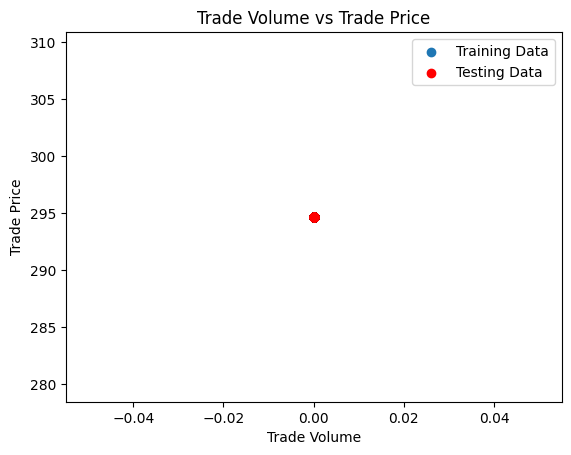

In [15]:
import matplotlib.pyplot as plt

# Load the dataset
df_test = pd.read_csv('../sample_data/sample_features.csv')
df_test['Trade_Price'] = df_test['Trade_Price'].fillna(df_test['Trade_Price'].median())

# Selecting features for the model (adjust as necessary)
features = ['Trade_Volume', 'Bid_Price', 'Offer_Price']  # Example features
target = 'Trade_Price'

# Drop rows with missing target or features
df_test = df_test.dropna(subset=[target] + features)

# Check if the DataFrame is empty
if df_test.empty:
    print("No data available after removing missing values.")
else:
    # Define X (features) and y (target)
    X = df_test[features]
    y = df_test[target]

    # Adding a constant to the model (important for OLS regression)
    X = sm.add_constant(X)

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Print model summary
    print(model.summary())

    # Save the model to a file
    model_filename = 'ols_model/ols_model.pkl'
    joblib.dump(model, model_filename)

    print(f"Model saved as {model_filename}")

# Visualization plot
plt.scatter(X_train['Trade_Volume'], y_train, label='Training Data')
plt.scatter(X_test['Trade_Volume'], y_test, color='red', label='Testing Data')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Volume vs Trade Price')
plt.legend()
plt.savefig("ols_model/plot.png")
plt.show()


### Push Files to HuggingFace

For write access you will need to use a user-access token. You can create one by going to your profile settings and clicking on "New token". Make sure to copy the token after creating it, as you won't be able to access it afterwards.

In [8]:
# push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/ols_model.pkl",
    path_in_repo="ols_model/ols_model.pkl",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)

ols_model.pkl:   0%|          | 0.00/197k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/taqdatabase/OLS/commit/66d4ab8a2c246c2e2c2b94bbfd823a11a0f3b784', commit_message='Upload ols_model/ols_model.pkl with huggingface_hub', commit_description='', oid='66d4ab8a2c246c2e2c2b94bbfd823a11a0f3b784', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
# push the plot to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/plot.png",
    path_in_repo="ols_model/plots/plot.png",   # Change this to the desired path in the repo
    repo_id="taqdatabase/OLS",      # Change "username/repo_name" to your Hugging Face Hub repo
    repo_type="model"                # Use "model" or "dataset" depending on the repository type
)

CommitInfo(commit_url='https://huggingface.co/taqdatabase/OLS/commit/249e2f8c771966bb6462a1f8f48d57156ad7c06e', commit_message='Upload ols_model/plots/plot.png with huggingface_hub', commit_description='', oid='249e2f8c771966bb6462a1f8f48d57156ad7c06e', pr_url=None, pr_revision=None, pr_num=None)


### Load Model from HuggingFace Hub

In [6]:
snapshot_download(repo_id="taqdatabase/OLS")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

'/Users/michael/.cache/huggingface/hub/models--taqdatabase--OLS/snapshots/5c2fa077218651724dac2c16a9db47d87ee74dc9'

# To do
1. add parameter estimate
2. chart with intervals/estimate and p-values